In [1]:
import numpy as np

In [2]:
class SparseMatrix:
    __array_priority__ = 1
    def __init__(self, rows, cols, vals_array):
        if isinstance(vals_array, list):
            vals_array = np.array(vals_array)
        if not isinstance(vals_array, np.ndarray):
            vals_array = np.array(vals_array)
        if vals_array.shape != (rows, cols):
            raise ValueError(f"Dimensions don't match: {vals_array.shape} != {(rows, cols)}. "
                             "Provide numpy 2-dimensional array or check sizes.")
                          
        self._rows, self._cols = rows, cols
        self.matrix = [(ind_row, ind_col, vals_array[ind_row, ind_col])
                      for ind_row in range(self._rows)
                      for ind_col in range(self._cols)
                      if vals_array[ind_row, ind_col] != 0]
        
    def transpose(self):
        tr = np.zeros((self._cols, self._rows))
        for i, j, value in self.matrix:
            tr[j, i] = value
        return SparseMatrix(self._cols, self._rows, tr)

    def __matmul__(self, right):
        if not isinstance(right, np.ndarray):
            right = np.array(right)
        if self._cols != right.shape[0]:
            raise ValueError(f"Dimensions don't match: rows from {right.shape} != {self._cols}")
        
        res = np.zeros(self._rows)
        for i, j, value in self.matrix:
            res[i] += right[j] * value
        return res
    
    def __rmatmul__(self, left):
        if not isinstance(left, np.ndarray):
            left = np.array(left)
        if self._rows != left.shape[0]:
            raise ValueError(f"Dimensions don't match: cols from {left.shape} != {self._rows}")
        
        res = np.zeros(self._cols)
        for i, j, value in self.matrix:
            res[j] += left[i] * value
        return res

In [3]:
def test_matrix(size=10):
    for _ in range(size):
        rows, cols = np.random.randint(1, 1000, 2)
        left_vector = np.random.rand(rows)
        right_vector = np.random.rand(cols)
    
        np_matrix = np.random.rand(rows, cols)
    
        left_vector @ np_matrix
    
        sparse = SparseMatrix(rows, cols, np_matrix)
    
        delta_right = np.linalg.norm(sparse @ right_vector - np_matrix @ right_vector)
        assert delta_right <= 10 ** -10
        
        delta_left = np.linalg.norm(left_vector @ sparse - left_vector @ np_matrix)
        assert delta_left <= 10 ** -10
    
    return 'ok'

In [4]:
test_matrix()

'ok'

In [5]:
import time

def test_time_difference(rows=1000, cols=5000, nonzero=10):
    def multiply_return_time(left, right):
        start = time.time()
        left @ right
        finish = time.time()
        
        return finish - start
    
    left_vector = np.random.rand(rows)
    right_vector = np.random.rand(cols)
    np_matrix = np.zeros((rows, cols))

    # selecting non-zero ind
    xs, ys = np.random.randint(0, rows, nonzero), np.random.randint(0, cols, nonzero)
    np_matrix[xs, ys] = np.random.rand()
    
    sparse = SparseMatrix(rows, cols, np_matrix) 
    sparse_time = multiply_return_time(sparse, right_vector)
    general_time = multiply_return_time(np_matrix, right_vector)
    
    return general_time / sparse_time


In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

nonzeros = [0, 10, 15, 20, 30, 50] + list(range(100, 1_000, 100))
times = []

for x in tqdm(nonzeros):
    times.append(test_time_difference(nonzero=x))

plt.figure(figsize=(10, 10))
plt.title('Матрица 1000x5000, сравниваем время работы умножения')
plt.xlabel('кол-во ненулевых элементов')
plt.ylabel('во сколько раз наше умножение работает быстрее, чем numpy')
plt.axhline(1, color='red', label='одинаково время')
plt.plot(nonzeros, times, label='отношение времен')
plt.grid(True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
# минимизируем || Ax - b || => минимизируем x^T * (A^T * A) * x - (2A^T * b)^T * x + b^T * b
def conjugate_gradient(A, b, x0):
    x = x0
    At = A.transpose()
    b = At @ b
    v = At @ (A @ x) - b
    d = v
    v_norm = np.dot(v, v)
    diffs = [x]

    for i in range(len(b)):
        Ad = At @ (A @ d)
        alpha = v_norm / (d @ Ad)
        x = x - alpha * d
        v = v - alpha * Ad
        new_v = np.dot(v, v)
        d = v + (new_v / v_norm) * d
        v_norm = new_v
        diffs.append(x)
    return diffs
    

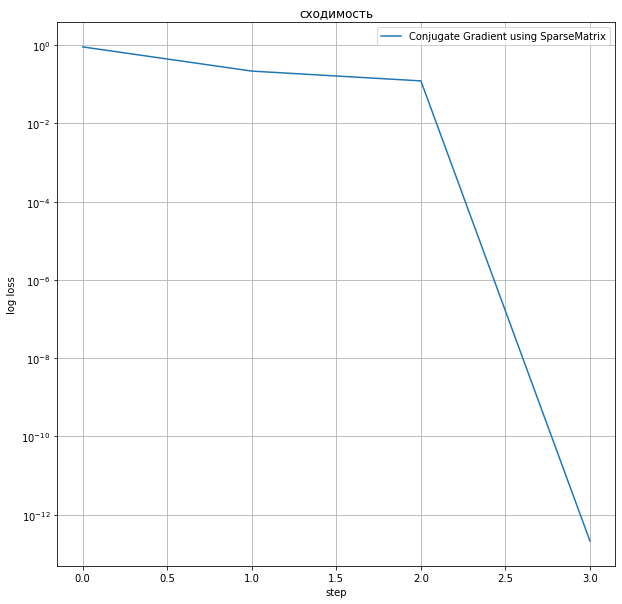

In [8]:
import matplotlib.pyplot as plt

size = 3

A = np.random.rand(size, size)
b = np.random.rand(size)
x0 = np.zeros_like(b)
A = SparseMatrix(size, size, A)
diffs = conjugate_gradient(A, b, x0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(True)
ax.set_title('сходимость')
ax.set_yscale('log')
ax.set_ylabel('log loss')
ax.set_xlabel('step')
ax.plot([np.linalg.norm(A @ x - b) for x in diffs], label='Conjugate Gradient using SparseMatrix')
ax.legend()